# Full Experiment with CatBoost Models

This notebook runs a complete experiment using all available features with both CatBoostClassifier and CatBoostRanker models.

In [1]:
import os
import polars as pl
import pandas as pd
import matplotlib.pyplot as plt
import json
import time

from lavka_recsys import Config, Experiment, setup_logging

In [2]:
setup_logging()

<Logger lavka_recsys (DEBUG)>

## Baseline Experiments

First, let's see how well a model that outputs random predictions does.

In [ ]:
# Create experiment
config = (Config
    .load('default_config.yaml')
    .set('feature_generators', ['random_noise'])
    .set('model.type', 'random_baseline')
)
random_experiment = Experiment("random_baseline", config)

# Setup and run
start_time = time.time()
random_experiment.setup()
random_results = random_experiment.run()
random_time = time.time() - start_time

# Print metrics
print(f"\nRandom Baseline Results (completed in {random_time:.2f} seconds):")
for metric, value in random_results['metrics'].items():
    print(f"  {metric}: {value:.6f}")

2025-05-05 17:04:52,189 - lavka_recsys.Experiment(random_baseline_587898) - INFO - Initialized experiment: random_baseline_587898
2025-05-05 17:04:52,198 - lavka_recsys.Experiment(random_baseline_587898) - INFO - Config saved: results/random_baseline_587898_config.json
2025-05-05 17:04:52,199 - lavka_recsys.Experiment(random_baseline_587898) - INFO - Setting up experiment environment...
2025-05-05 17:04:52,201 - lavka_recsys.DataLoader - INFO - Loading training data from ../../data/lavka/train.parquet


2025-05-05 17:04:52,508 - lavka_recsys.DataLoader - INFO - Loading test data from ../../data/lavka/test.parquet
2025-05-05 17:04:52,924 - lavka_recsys.DataLoader - INFO - Holdout Split:
2025-05-05 17:04:52,951 - lavka_recsys.DataLoader - INFO -   train: 2022-12-31 18:46:42 → 2024-01-03 17:31:52 (15_070_276 rows, 367 days)
2025-05-05 17:04:52,955 - lavka_recsys.DataLoader - INFO -   holdout: 2024-01-03 17:56:48 → 2024-02-02 17:34:51 (1_438_338 rows, 29 days)
2025-05-05 17:04:52,956 - lavka_recsys.Experiment(random_baseline_587898) - INFO - Setup complete.
2025-05-05 17:04:52,957 - lavka_recsys.Experiment(random_baseline_587898) - INFO - Starting experiment run...
2025-05-05 17:04:53,437 - lavka_recsys.DataLoader - INFO - Validation Split:
2025-05-05 17:04:53,459 - lavka_recsys.DataLoader - INFO -   train_history: 2022-12-31 18:46:42 → 2023-11-04 17:16:23 (12_082_523 rows, 307 days)
2025-05-05 17:04:53,463 - lavka_recsys.DataLoader - INFO -   train_target: 2023-11-04 18:19:12 → 2023-12-0

In [4]:
# random_experiment.create_submission()

Kaggle Public Score = `0.30071`.

Now let's consider a baseline that only considers popularity (i.e. `product_total_purchases`).

In [ ]:
# Create experiment
config = (Config
    .load('default_config.yaml')
    .set('feature_generators', ['product_stats'])
    .set('model.type', 'single_feature')
    .set('model.config.single_feature.feature_name', 'product_total_purchases')
    .set('model.config.single_feature.desc', True)
)
pop_experiment = Experiment(
    "popularity_baseline",
    config
)

# Setup and run
start_time = time.time()
pop_experiment.setup()
pop_results = pop_experiment.run()
pop_time = time.time() - start_time

# Print metrics
print(f"\nPopularity Baseline Results (completed in {pop_time:.2f} seconds):")
for metric, value in pop_results['metrics'].items():
    print(f"  {metric}: {value:.6f}")

2025-05-05 17:05:05,667 - lavka_recsys.Experiment(popularity_baseline_03697e) - INFO - Initialized experiment: popularity_baseline_03697e
2025-05-05 17:05:05,674 - lavka_recsys.Experiment(popularity_baseline_03697e) - INFO - Config saved: results/popularity_baseline_03697e_config.json
2025-05-05 17:05:05,675 - lavka_recsys.Experiment(popularity_baseline_03697e) - INFO - Setting up experiment environment...
2025-05-05 17:05:05,677 - lavka_recsys.DataLoader - INFO - Loading training data from ../../data/lavka/train.parquet


2025-05-05 17:05:06,006 - lavka_recsys.DataLoader - INFO - Loading test data from ../../data/lavka/test.parquet
2025-05-05 17:05:06,297 - lavka_recsys.DataLoader - INFO - Holdout Split:
2025-05-05 17:05:06,324 - lavka_recsys.DataLoader - INFO -   train: 2022-12-31 18:46:42 → 2024-01-03 17:31:52 (15_070_276 rows, 367 days)
2025-05-05 17:05:06,328 - lavka_recsys.DataLoader - INFO -   holdout: 2024-01-03 17:56:48 → 2024-02-02 17:34:51 (1_438_338 rows, 29 days)
2025-05-05 17:05:06,329 - lavka_recsys.Experiment(popularity_baseline_03697e) - INFO - Setup complete.
2025-05-05 17:05:06,330 - lavka_recsys.Experiment(popularity_baseline_03697e) - INFO - Starting experiment run...
2025-05-05 17:05:06,725 - lavka_recsys.DataLoader - INFO - Validation Split:
2025-05-05 17:05:06,745 - lavka_recsys.DataLoader - INFO -   train_history: 2022-12-31 18:46:42 → 2023-11-04 17:16:23 (12_082_523 rows, 307 days)
2025-05-05 17:05:06,749 - lavka_recsys.DataLoader - INFO -   train_target: 2023-11-04 18:19:12 → 2

In [7]:
# pop_experiment.create_submission()

Kaggle Public Score = `0.33188`.

## CatBoost Classifier Experiment

Run an experiment with CatBoost Classifier.

In [6]:
classifier_experiment = Experiment("catboost_classifier", (Config
    .load('default_config.yaml')
    .set('model.type', 'catboost_classifier')
))

# Setup and run
classifier_experiment.setup()
classifier_results = classifier_experiment.run()

# Print metrics
print(f"\nCatBoost Classifier Results:")
for metric, value in classifier_results['metrics'].items():
    print(f"  {metric}: {value:.6f}")

# Print feature importance
if 'feature_importance' in classifier_results:
    print("\nTop 10 Important Features:")
    top_features = sorted(classifier_results['feature_importance'].items(), 
                        key=lambda x: x[1], reverse=True)[:10]
    for feature, importance in top_features:
        print(f"  {feature}: {importance:.6f}")

2025-05-05 23:21:34,439 - lavka_recsys.Experiment(catboost_classifier_05fa4e) - INFO - Initialized experiment: catboost_classifier_05fa4e
2025-05-05 23:21:34,452 - lavka_recsys.Experiment(catboost_classifier_05fa4e) - INFO - Config saved: results/catboost_classifier_05fa4e_config.json
2025-05-05 23:21:34,453 - lavka_recsys.Experiment(catboost_classifier_05fa4e) - INFO - Setting up experiment environment...
2025-05-05 23:21:34,455 - lavka_recsys.DataLoader - INFO - Loading training data from ../../data/lavka/train.parquet


2025-05-05 23:21:34,762 - lavka_recsys.DataLoader - INFO - Loading test data from ../../data/lavka/test.parquet
2025-05-05 23:21:34,990 - lavka_recsys.DataLoader - INFO - Holdout Split:
2025-05-05 23:21:35,019 - lavka_recsys.DataLoader - INFO -   train: 2022-12-31 18:46:42 → 2024-01-03 17:31:52 (15_070_276 rows, 367 days)
2025-05-05 23:21:35,022 - lavka_recsys.DataLoader - INFO -   holdout: 2024-01-03 17:56:48 → 2024-02-02 17:34:51 (1_438_338 rows, 29 days)
2025-05-05 23:21:35,023 - lavka_recsys.Experiment(catboost_classifier_05fa4e) - INFO - Setup complete.
2025-05-05 23:21:35,025 - lavka_recsys.Experiment(catboost_classifier_05fa4e) - INFO - Starting experiment run...
2025-05-05 23:21:35,358 - lavka_recsys.DataLoader - INFO - Validation Split:
2025-05-05 23:21:35,382 - lavka_recsys.DataLoader - INFO -   train_history: 2022-12-31 18:46:42 → 2023-11-04 17:16:23 (12_082_523 rows, 307 days)
2025-05-05 23:21:35,386 - lavka_recsys.DataLoader - INFO -   train_target: 2023-11-04 18:19:12 → 2

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Default metric period is 5 because AUC, NDCG is/are not implemented for GPU
Metric NDCG:top=10;type=Base is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time


2025-05-05 23:22:15,738 - lavka_recsys.Experiment(catboost_classifier_05fa4e) - INFO - Training completed in 37.41s
2025-05-05 23:22:15,742 - lavka_recsys.Experiment(catboost_classifier_05fa4e) - INFO - Evaluating on holdout.
2025-05-05 23:22:17,151 - lavka_recsys.CachedFeatureFactory - INFO - Using cached feature batch
2025-05-05 23:22:17,379 - lavka_recsys.CatBoostClassifierModel - INFO - Converting 'user_segment' to string for CatBoost
2025-05-05 23:22:17,415 - lavka_recsys.CatBoostClassifierModel - INFO - Converting 'city_name' to string for CatBoost
2025-05-05 23:22:17,436 - lavka_recsys.CatBoostClassifierModel - INFO - Converting 'source_type' to string for CatBoost
2025-05-05 23:22:32,059 - lavka_recsys.Experiment(catboost_classifier_05fa4e) - INFO - Run results saved: results/catboost_classifier_05fa4e_results.json
2025-05-05 23:22:32,061 - lavka_recsys.Experiment(catboost_classifier_05fa4e) - INFO - Run finished and results saved.

CatBoost Classifier Results:
  auc: 0.852456


In [6]:
classifier_experiment.create_submission()

2025-05-05 21:17:27,157 - lavka_recsys.Experiment(catboost_classifier_ebe53b) - INFO - Computing predictions...
2025-05-05 21:17:27,163 - lavka_recsys.DataLoader - INFO - Holdout data merged back into training data.
2025-05-05 21:17:27,198 - lavka_recsys.DataLoader - INFO - Validation Split:
2025-05-05 21:17:27,228 - lavka_recsys.DataLoader - INFO -   history: 2022-12-31 18:46:42 → 2024-01-03 17:31:52 (15_070_276 rows, 367 days)
2025-05-05 21:17:27,232 - lavka_recsys.DataLoader - INFO -   target: 2024-01-03 17:56:48 → 2024-02-02 17:34:51 (1_438_338 rows, 29 days)
2025-05-05 21:17:28,350 - lavka_recsys.CachedFeatureFactory - INFO - Using cached feature batch
2025-05-05 21:17:28,352 - lavka_recsys.ModelFactory - INFO - Creating catboost_classifier model with params: {'loss_function': 'Logloss', 'eval_metric': 'AUC', 'early_stopping_rounds': 50, 'custom_metric': ['AUC', 'NDCG:top=10'], 'task_type': 'GPU', 'devices': '4,5', 'thread_count': -1}
2025-05-05 21:17:28,599 - lavka_recsys.CatBoos

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Default metric period is 5 because AUC, NDCG is/are not implemented for GPU
Metric NDCG:top=10;type=Base is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time


2025-05-05 21:18:26,595 - lavka_recsys.Experiment(catboost_classifier_ebe53b) - INFO - Training completed in 58.24s
2025-05-05 21:18:26,600 - lavka_recsys.DataLoader - INFO - Holdout data merged back into training data.
2025-05-05 21:18:26,633 - lavka_recsys.CachedFeatureFactory - INFO - Generating feature batch
2025-05-05 21:18:26,636 - lavka_recsys.FeatureFactory - INFO - Invoking feature generators: source_type, count_purchase_user_product, count_purchase_user_store, ctr_product, cart_to_purchase_rate, purchase_view_ratio, recency_user_product, user_stats, product_stats, store_stats, city_stats, product_temporal_patterns, recency_user_store, time_features, time_window_user_product, session_features, frequency_features, product_popularity_trend, cross_features, user_segments, memory-based-cf, npmi-cf, puresvd-cf, svd-cf, bpr-popular


  0%|          | 0/100 [00:00<?, ?it/s]

BPR processing:   0%|          | 0/807 [00:00<?, ?it/s]

2025-05-05 21:19:58,736 - lavka_recsys.FeatureFactory - INFO - Joined features
2025-05-05 21:19:58,737 - lavka_recsys.FeatureFactory - INFO - All column names: {'user_total_purchases', 'product_total_purchases', 'is_weekend', 'user_product_purchase_cross', 'views_month_u_p', 'user_total_views', 'interactions_week_u_p', 'std_purchase_hour', 'day_of_week', 'session_purchases', 'count_purchase_u_s', 'user_product_store_cross', 'mean_interval_days', 'purchase_trend', 'product_total_views', 'source_type', 'session_unique_stores', 'purchase_view_ratio', 'purchases_week_u_p', 'cf_score', 'session_unique_products', 'hour_of_day', 'product_total_interactions', 'session_length', 'city_total_views', 'days_since_interaction_u_s', 'interactions_day_u_p', 'user_segment', 'month', 'purchases_month_u_p', 'user_store_purchase_cross', 'user_total_interactions', 'store_total_interactions', 'most_common_purchase_day', 'days_since_interaction_u_p', 'product_unique_users', 'views_week_u_p', 'svd_cf_score', 

index,request_id
u32,u64
10580,18249322439088082464
175497,18249322439088082464
194218,18249322439088082464
240500,18249322439088082464
196870,6482228966567928247
…,…
185742,9521914430913884488
158989,8125801675136871061
246665,8125801675136871061


Kaggle Public Score: `NDCG@10 = 0.40962`.

## CatBoost Ranker Experiment

Run an experiment with CatBoost Ranker.

In [4]:
ranker_experiment = Experiment("catboost_ranker", (Config
    .load('default_config.yaml')
    .set('model.type', 'catboost_ranker')
    .set('model.config.catboost_ranker.iterations', 300)
))

# Setup and run
ranker_experiment.setup()
ranker_results = ranker_experiment.run()

# Print metrics
print(f"\nCatBoost Ranker Results:")
for metric, value in ranker_results['metrics'].items():
    print(f"  {metric}: {value:.6f}")

# Print feature importance
if 'feature_importance' in ranker_results:
    print("\nTop 10 Important Features:")
    top_features = sorted(ranker_results['feature_importance'].items(), 
                        key=lambda x: x[1], reverse=True)[:10]
    for feature, importance in top_features:
        print(f"  {feature}: {importance:.6f}")

2025-05-05 23:09:36,899 - lavka_recsys.Experiment(catboost_ranker_9239b0) - INFO - Initialized experiment: catboost_ranker_9239b0
2025-05-05 23:09:36,908 - lavka_recsys.Experiment(catboost_ranker_9239b0) - INFO - Config saved: results/catboost_ranker_9239b0_config.json
2025-05-05 23:09:36,909 - lavka_recsys.Experiment(catboost_ranker_9239b0) - INFO - Setting up experiment environment...
2025-05-05 23:09:36,911 - lavka_recsys.DataLoader - INFO - Loading training data from ../../data/lavka/train.parquet


2025-05-05 23:09:37,200 - lavka_recsys.DataLoader - INFO - Loading test data from ../../data/lavka/test.parquet
2025-05-05 23:09:37,487 - lavka_recsys.DataLoader - INFO - Holdout Split:
2025-05-05 23:09:37,515 - lavka_recsys.DataLoader - INFO -   train: 2022-12-31 18:46:42 → 2024-01-03 17:31:52 (15_070_276 rows, 367 days)
2025-05-05 23:09:37,519 - lavka_recsys.DataLoader - INFO -   holdout: 2024-01-03 17:56:48 → 2024-02-02 17:34:51 (1_438_338 rows, 29 days)
2025-05-05 23:09:37,520 - lavka_recsys.Experiment(catboost_ranker_9239b0) - INFO - Setup complete.
2025-05-05 23:09:37,521 - lavka_recsys.Experiment(catboost_ranker_9239b0) - INFO - Starting experiment run...
2025-05-05 23:09:37,891 - lavka_recsys.DataLoader - INFO - Validation Split:
2025-05-05 23:09:37,914 - lavka_recsys.DataLoader - INFO -   train_history: 2022-12-31 18:46:42 → 2023-11-04 17:16:23 (12_082_523 rows, 307 days)
2025-05-05 23:09:37,918 - lavka_recsys.DataLoader - INFO -   train_target: 2023-11-04 18:19:12 → 2023-12-0

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Default metric period is 5 because PFound, PrecisionAt, RecallAt, NDCG is/are not implemented for GPU
Metric PFound is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time
Metric NDCG:top=10;type=Base is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time
Metric NDCG:top=10;type=Base is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time
Metric PrecisionAt:top=10 is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time
Metric RecallAt:top=10 is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time


2025-05-05 23:10:40,484 - lavka_recsys.Experiment(catboost_ranker_9239b0) - INFO - Training completed in 60.07s
2025-05-05 23:10:40,489 - lavka_recsys.Experiment(catboost_ranker_9239b0) - INFO - Evaluating on holdout.
2025-05-05 23:10:40,554 - lavka_recsys.CachedFeatureFactory - INFO - Generating feature batch
2025-05-05 23:10:40,555 - lavka_recsys.FeatureFactory - INFO - Invoking feature generators: source_type, count_purchase_user_product, count_purchase_user_store, ctr_product, cart_to_purchase_rate, purchase_view_ratio, recency_user_product, user_stats, product_stats, store_stats, city_stats, product_temporal_patterns, recency_user_store, time_features_cycl, time_window_user_product, session_features, frequency_features, product_popularity_trend, cross_features, user_segments, memory-based-cf, npmi-cf, puresvd-cf, svd-cf, bpr-popular


  0%|          | 0/100 [00:00<?, ?it/s]

BPR processing:   0%|          | 0/1283 [00:00<?, ?it/s]

2025-05-05 23:12:30,052 - lavka_recsys.FeatureFactory - INFO - Joined features
2025-05-05 23:12:30,053 - lavka_recsys.FeatureFactory - INFO - All column names: {'city_total_purchases', 'hour_of_day_sin', 'month_sin', 'user_total_interactions', 'interaction_trend', 'svd_cf_score', 'views_week_u_p', 'views_month_u_p', 'product_total_interactions', 'session_purchases', 'is_weekend', 'purchases_week_u_p', 'session_duration_seconds', 'store_total_purchases', 'npmi_cf_score', 'session_unique_products', 'puresvd_cf_score', 'day_of_week_sin', 'mean_interval_days', 'purchases_month_u_p', 'session_length', 'hour_relevance', 'store_total_interactions', 'product_total_purchases', 'count_purchase_u_s', 'views_day_u_p', 'cart_to_purchase_rate', 'interactions_week_u_p', 'days_since_interaction_u_p', 'product_total_views', 'product_unique_users', 'user_product_store_cross', 'cf_score', 'user_segment', 'city_total_views', 'purchases_day_u_p', 'bpr_popular_score', 'most_common_purchase_day', 'session_un

In [5]:
ranker_experiment.create_submission()

2025-05-05 23:13:55,497 - lavka_recsys.Experiment(catboost_ranker_9239b0) - INFO - Computing predictions...
2025-05-05 23:13:55,506 - lavka_recsys.DataLoader - INFO - Holdout data merged back into training data.
2025-05-05 23:13:55,558 - lavka_recsys.DataLoader - INFO - Validation Split:
2025-05-05 23:13:55,587 - lavka_recsys.DataLoader - INFO -   history: 2022-12-31 18:46:42 → 2024-01-03 17:31:52 (15_070_276 rows, 367 days)
2025-05-05 23:13:55,591 - lavka_recsys.DataLoader - INFO -   target: 2024-01-03 17:56:48 → 2024-02-02 17:34:51 (1_438_338 rows, 29 days)
2025-05-05 23:13:56,931 - lavka_recsys.CachedFeatureFactory - INFO - Using cached feature batch
2025-05-05 23:13:56,934 - lavka_recsys.ModelFactory - INFO - Creating catboost_ranker model with params: {'iterations': 300, 'loss_function': 'YetiRankPairwise', 'eval_metric': 'NDCG:top=10', 'early_stopping_rounds': 50, 'custom_metric': ['NDCG:top=10', 'PrecisionAt:top=10', 'RecallAt:top=10'], 'task_type': 'GPU', 'devices': '4,5', 'thr

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Default metric period is 5 because PFound, PrecisionAt, RecallAt, NDCG is/are not implemented for GPU
Metric PFound is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time
Metric NDCG:top=10;type=Base is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time
Metric NDCG:top=10;type=Base is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time
Metric PrecisionAt:top=10 is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time
Metric RecallAt:top=10 is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time


2025-05-05 23:14:44,356 - lavka_recsys.Experiment(catboost_ranker_9239b0) - INFO - Training completed in 47.42s
2025-05-05 23:14:44,365 - lavka_recsys.DataLoader - INFO - Holdout data merged back into training data.
2025-05-05 23:14:44,432 - lavka_recsys.CachedFeatureFactory - INFO - Generating feature batch
2025-05-05 23:14:44,433 - lavka_recsys.FeatureFactory - INFO - Invoking feature generators: source_type, count_purchase_user_product, count_purchase_user_store, ctr_product, cart_to_purchase_rate, purchase_view_ratio, recency_user_product, user_stats, product_stats, store_stats, city_stats, product_temporal_patterns, recency_user_store, time_features_cycl, time_window_user_product, session_features, frequency_features, product_popularity_trend, cross_features, user_segments, memory-based-cf, npmi-cf, puresvd-cf, svd-cf, bpr-popular


  0%|          | 0/100 [00:00<?, ?it/s]

BPR processing:   0%|          | 0/807 [00:00<?, ?it/s]

2025-05-05 23:16:16,511 - lavka_recsys.FeatureFactory - INFO - Joined features
2025-05-05 23:16:16,513 - lavka_recsys.FeatureFactory - INFO - All column names: {'city_total_purchases', 'hour_of_day_sin', 'month_sin', 'user_total_interactions', 'interaction_trend', 'svd_cf_score', 'views_week_u_p', 'views_month_u_p', 'product_total_interactions', 'session_purchases', 'is_weekend', 'purchases_week_u_p', 'session_duration_seconds', 'store_total_purchases', 'npmi_cf_score', 'session_unique_products', 'puresvd_cf_score', 'day_of_week_sin', 'mean_interval_days', 'purchases_month_u_p', 'session_length', 'hour_relevance', 'store_total_interactions', 'product_total_purchases', 'count_purchase_u_s', 'views_day_u_p', 'cart_to_purchase_rate', 'interactions_week_u_p', 'days_since_interaction_u_p', 'product_total_views', 'product_unique_users', 'user_product_store_cross', 'cf_score', 'user_segment', 'city_total_views', 'purchases_day_u_p', 'bpr_popular_score', 'most_common_purchase_day', 'session_un

index,request_id
u32,u64
95970,18037997914549181289
118676,15207620247861633206
131326,15207620247861633206
225106,15207620247861633206
41187,9106065009157563665
…,…
201945,13718769544022533931
114866,2499694595598766468
275274,6169200570541966232


Kaggle Public Score `NDCG@10 = 0.41037`

In [3]:
ranker_experiment = Experiment("catboost_ranker", (Config
    .load('default_config.yaml')
    .set('model.type', 'catboost_ranker')
    .set('model.config.catboost_ranker.iterations', 300)
    .set('target', 'Weighted')
))

# Setup and run
ranker_experiment.setup()
ranker_results = ranker_experiment.run()

# Print metrics
print(f"\nCatBoost Ranker Results:")
for metric, value in ranker_results['metrics'].items():
    print(f"  {metric}: {value:.6f}")

# Print feature importance
if 'feature_importance' in ranker_results:
    print("\nTop 10 Important Features:")
    top_features = sorted(ranker_results['feature_importance'].items(), 
                        key=lambda x: x[1], reverse=True)[:10]
    for feature, importance in top_features:
        print(f"  {feature}: {importance:.6f}")

2025-05-05 23:51:01,670 - lavka_recsys.Experiment(catboost_ranker_ebb94e) - INFO - Initialized experiment: catboost_ranker_ebb94e
2025-05-05 23:51:01,680 - lavka_recsys.Experiment(catboost_ranker_ebb94e) - INFO - Config saved: results/catboost_ranker_ebb94e_config.json
2025-05-05 23:51:01,681 - lavka_recsys.Experiment(catboost_ranker_ebb94e) - INFO - Setting up experiment environment...
2025-05-05 23:51:01,683 - lavka_recsys.DataLoader - INFO - Loading training data from ../../data/lavka/train.parquet
2025-05-05 23:51:02,007 - lavka_recsys.DataLoader - INFO - Loading test data from ../../data/lavka/test.parquet
2025-05-05 23:51:02,444 - lavka_recsys.DataLoader - INFO - Holdout Split:
2025-05-05 23:51:02,474 - lavka_recsys.DataLoader - INFO -   train: 2022-12-31 18:46:42 → 2024-01-03 17:31:52 (15_070_276 rows, 367 days)
2025-05-05 23:51:02,480 - lavka_recsys.DataLoader - INFO -   holdout: 2024-01-03 17:56:48 → 2024-02-02 17:34:51 (1_438_338 rows, 29 days)
2025-05-05 23:51:02,481 - lavka

  0%|          | 0/100 [00:00<?, ?it/s]

BPR processing:   0%|          | 0/1213 [00:00<?, ?it/s]

2025-05-05 23:52:36,094 - lavka_recsys.FeatureFactory - INFO - Joined features
2025-05-05 23:52:36,097 - lavka_recsys.FeatureFactory - INFO - All column names: {'session_unique_products', 'user_product_purchase_cross', 'hour_of_day_sin', 'city_total_interactions', 'purchases_month_u_p', 'product_total_views', 'interactions_week_u_p', 'session_unique_stores', 'count_purchase_u_p', 'purchase_view_ratio', 'interaction_trend', 'ctr_product', 'views_week_u_p', 'count_purchase_u_s', 'interactions_day_u_p', 'purchases_day_u_p', 'purchase_trend', 'user_total_interactions', 'session_length', 'svd_cf_score', 'cf_score', 'days_since_interaction_u_s', 'city_total_views', 'session_duration_seconds', 'city_unique_stores', 'source_type', 'most_common_purchase_day', 'product_unique_users', 'store_unique_products', 'purchases_week_u_p', 'bpr_popular_score', 'month_sin', 'product_total_purchases', 'product_total_interactions', 'std_purchase_hour', 'user_store_purchase_cross', 'views_month_u_p', 'city_na

TypeError: unexpected value while building Series of type Int64; found value of type Float64: 0.85

Hint: Try setting `strict=False` to allow passing data with mixed types.

## 7. Feature Importance Comparison

Top 20 Features by Average Importance:


,Feature,Classifier Importance,Ranker Importance,Average Importance
0,source_type,66.951228,78.145273,72.548251
1,purchase_view_ratio,4.511302,3.471939,3.991620
2,count_purchase_u_p,4.048052,2.749533,3.398792
3,purchases_month_u_p,2.470713,0.767363,1.619038
4,mean_interval_days,1.589401,0.721399,1.155400
5,bpr_popular_score,0.642718,1.322204,0.982461
6,npmi_cf_score,1.720794,0.205699,0.963246
7,cf_score,0.997711,0.675051,0.836381
8,cart_to_purchase_rate,0.805088,0.852040,0.828564
9,user_total_interactions,1.537934,0.110180,0.824057


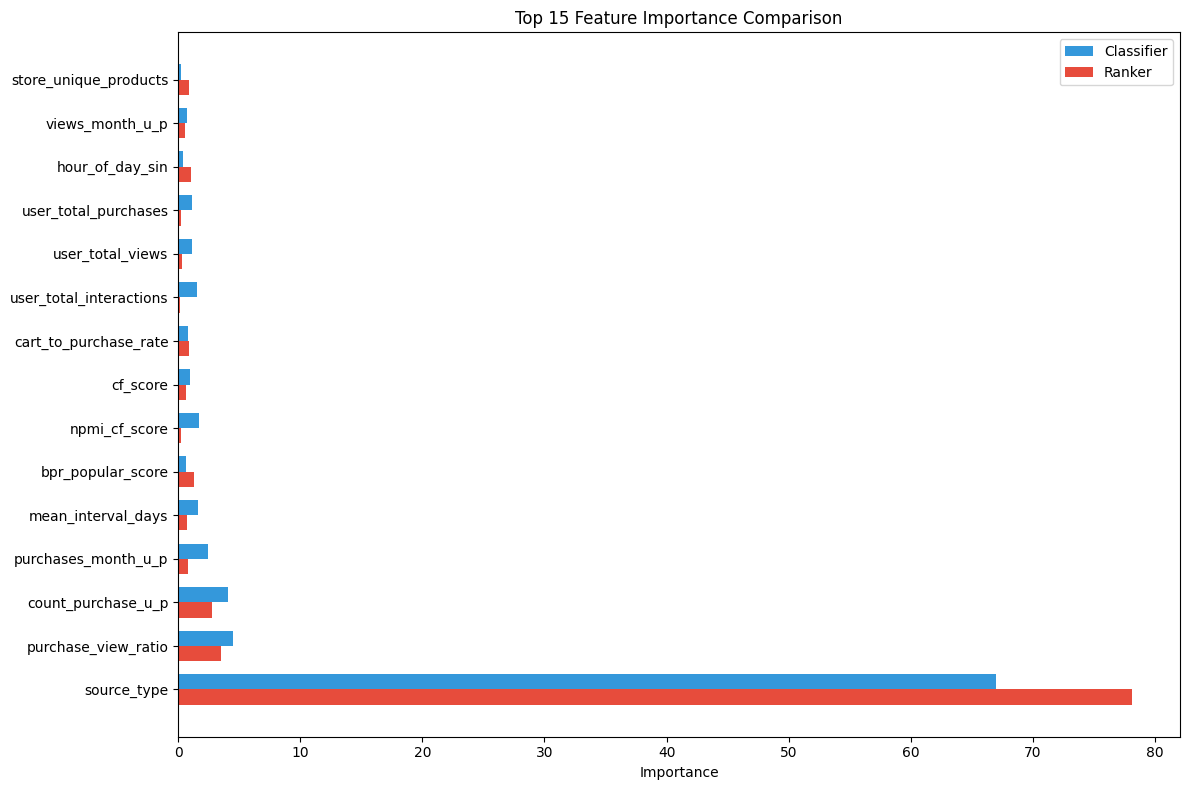

In [7]:
# Compare feature importance between models
if 'feature_importance' in classifier_results and 'feature_importance' in ranker_results:
    # Get all features from both models
    all_features = set(list(classifier_results['feature_importance'].keys()) + 
                        list(ranker_results['feature_importance'].keys()))
    
    # Create comparison dataframe
    fi_comparison = {'Feature': []}
    fi_comparison['Classifier Importance'] = []
    fi_comparison['Ranker Importance'] = []
    
    for feature in all_features:
        fi_comparison['Feature'].append(feature)
        fi_comparison['Classifier Importance'].append(
            classifier_results['feature_importance'].get(feature, 0))
        fi_comparison['Ranker Importance'].append(
            ranker_results['feature_importance'].get(feature, 0))
        
    # Convert to DataFrame and sort by average importance
    fi_df = pd.DataFrame(fi_comparison)
    fi_df['Average Importance'] = (fi_df['Classifier Importance'] + fi_df['Ranker Importance']) / 2
    fi_df = fi_df.sort_values('Average Importance', ascending=False).reset_index(drop=True)
    
    # Save to results directory
    # fi_df.to_csv(f"{results_dir}/feature_importance_comparison.csv", index=False)
    
    # Display top features
    print("Top 20 Features by Average Importance:")
    display(fi_df.head(20))
    
    # Plot top 15 features
    plt.figure(figsize=(12, 8))
    top_n = 15
    top_features = fi_df.head(top_n)
    
    x = range(len(top_features))
    width = 0.35
    
    plt.barh([p + width/2 for p in x], top_features['Classifier Importance'], 
            height=width, label='Classifier', color='#3498db')
    plt.barh([p - width/2 for p in x], top_features['Ranker Importance'], 
            height=width, label='Ranker', color='#e74c3c')
    
    plt.yticks(x, top_features['Feature'])
    plt.xlabel('Importance')
    plt.title(f'Top {top_n} Feature Importance Comparison')
    plt.legend()
    plt.tight_layout()
    plt.show()